# Tutorial 11 - Predictive versus generative modelling

By the end of this section, students will be able to:

1. Give examples of questions that can be answered by generative models and others that can be answered by predictive models.
2. Discuss how the research question being asked impacts the statistical modelling procedures.
3. Discuss why the model obtained directly from lasso is not the most suitable model for generative modelling and how post-lasso is one way to address this problem.
4. Write a computer script to perform post-lasso and use it to estimate a generative model.
5. Discuss post inference problems (e.g., double dipping into the data set) and current practical solutions available to address these (e.g., data-splitting techniques).
6. Write a computer script to apply currently available practical solutions to post inference problems.
7. Discuss how the research question being asked impacts the communication of the results.

In [1]:
# Loading packages
library(car)
library(tidyverse)
library(broom)
library(glmnet)
library(leaps)
library(faraway)
library(mltools)
source("tests_tutorial_11.r")

Loading required package: carData

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::recode() masks car::recode()
✖ purrr::some()   masks car::some()
Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-2


Attaching package: ‘faraway’


The following objects are masked from ‘package:car’:

    logit, vif



Attaching package: ‘mltools’


The following object is masked from ‘package:tidyr’:

    replace_na



Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is 

## Model Selection: Ridge

We have also learned that *shrinkage methods* can be used to build predictive models. Some of these methods can also be used to select variables. In particular, *Ridge method* will not select variables since the estimated coefficients won't be shrunk to zero. 

> **Heads up:** Ridge method was first introduced in 1970 to address multicollinearity issues!

The function `glmnet` used to fit a Ridge regression uses a matrix of input variables, instead of the input variable names. 

In this tutorial, you will use the dataset `fat` from the library `faraway` to build a Ridge regression and use it to predict the `brozek` value for men in a test set. 

**Recall**: This dataset contains the percentage of body fat and a whole variety of body measurements (continuous variables) of 252 men. You will use the variable `brozek` as the response variable and a subset 14 variables to build different models. Additional information about the data can be found in [Johnson (1996)](https://www.tandfonline.com/doi/full/10.1080/10691898.1996.11910505). 

Run the code below to create the working data frame called `fat_sample` and build the objects needed in next problems:

The response variable `brozek` is the percent of body fat using Brozek's equation:

$$\texttt{brozek} = \frac{457}{\texttt{density}} - 414.2,$$

where body `density` is measured in $\text{g}/\text{cm}^3$.

The 14 input variables are:

- `age`: Age in $\text{years}$.
- `weight`: Weight in $\text{lb}$.
- `height`: Height in $\text{in}$.
- `adipos`: Adiposity index in $\text{kg}/\text{m}^2$.

$$\texttt{adipos} = \frac{\texttt{weight}}{\texttt{height}^2}$$

- `neck`: Neck circumference in $\text{cm}$.
- `chest`: Chest circumference in $\text{cm}$.
- `abdom`: Abdomen circumference at the umbilicus and level with the iliac crest in $\text{cm}$.
- `hip`: Hip circumference in $\text{cm}$.
- `thigh`: Thigh circumference in $\text{cm}$.
- `knee`: Knee circumference in $\text{cm}$.
- `ankle`: Ankle circumference in $\text{cm}$.
- `biceps`: Extended biceps circumference in $\text{cm}$.
- `forearm`: Forearm circumference in $\text{cm}$.
- `wrist`: Wrist circumference distal to the styloid processes in $\text{cm}$.

In [2]:
# Get a sample
fat_sample <- fat %>%
  select(
    brozek, age, weight, height, adipos, neck, chest, abdom,
    hip, thigh, knee, ankle, biceps, forearm, wrist
  )

# Split data into training and test sets
set.seed(123)

fat_sample$ID <- rownames(fat_sample)

training_fat <- sample_n(fat_sample, size = nrow(fat_sample) * 0.70,
  replace = FALSE
)

testing_fat <- anti_join(fat_sample,
  training_fat,
  by = "ID"
)

# Remove variable "ID"
training_fat <- training_fat  %>% select(-ID)
testing_fat <- testing_fat  %>% select(-ID)

# Build matrix and vector required by `glmnet`

fat_X_train <- model.matrix(object = brozek ~ age + weight + height + adipos + neck +
    chest + abdom + hip + thigh + knee + ankle + biceps +
    forearm + wrist,
  data = training_fat)[, -1]

fat_Y_train <- training_fat[, "brozek"]

**Question 1.0**
<br>{points: 1}

Now that we have our training data prepared in `fat_X_train` and `fat_Y_train`, we will select the value of $\lambda$ that provides the smallest $\text{MSE}_{\text{test}}$ using cross-validation. 

We can do this automatically with function `cv.glmnet()` where `x` is the matrix of input variables and `y` is vector of training responses that we prepared. 

> **Heads up**: the method of Ridge regression is defined when `alpha` is equal to zero. 

To select `lambda` we will use a **sequence** of values that goes from $\lambda = \exp(-5) = 0.0067$ to $\lambda = \exp(10) = 22026.5$. Internally, `glmnet` will use cross-validation to compare the test MSE at each of these values. Assign the function's output as `fat_cv_lambda_ridge`.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [3]:
set.seed(1234) # DO NOT CHANGE!

# fat_cv_lambda_ridge <- ...(
#   x = ..., y = ...,
#   alpha = ...,
#   lambda = exp(seq(-5, 10, 0.1))
# )

### BEGIN SOLUTION
fat_cv_lambda_ridge <- cv.glmnet(
  x = fat_X_train, y = fat_Y_train,
  alpha = 0,
  lambda = exp(seq(-5, 10, 0.1))
)
### END SOLUTION

In [4]:
test_1.0()

Test passed 🥳
Test passed 🎊
[1] "Success!"


**Question 1.1**
<br>{points: 1}

We can visualize the estimated test MSE at each value of lambda in the sequence by using `fat_cv_lambda_ridge` and `plot()`. 

The resulting plot will indicate the $\text{MSE}_{\text{test}}$ on the $y$-axis (error bars show the variation of the test error in the different folds) along with the range of $\lambda$ on the bottom $x$-axis on the natural log-scale. 

> **Heads up**: Ridge regression never shrinks estimators to zero, thus we see a value of `14` on the top $x$-axis. 

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

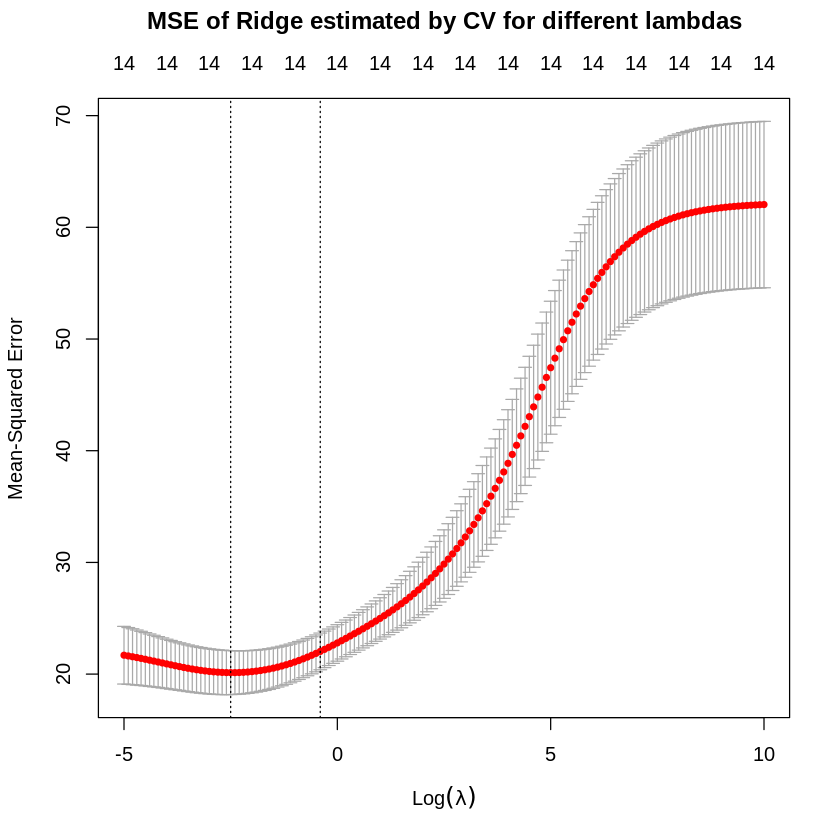

In [5]:
# plot_data <- ...
# plot(plot_data, main = "MSE of Ridge estimated by CV for different lambdas\n\n")

### BEGIN SOLUTION

plot_data <- fat_cv_lambda_ridge
plot(plot_data, main = "MSE of Ridge estimated by CV for different lambdas\n\n")
### END SOLUTION

In [6]:
test_1.1()

Test passed 😸
Test passed 🎊
[1] "Success!"


**Question 1.2**
<br>{points: 1}

The plot in **Question 1.1** also shows two vertical dotted lines. *Given an `object` coming from `cv.glmnet()`*, these lines correspond to two values of $\lambda$:

- $\hat{\lambda}_{\text{min}}$ which minimizes MSE. It can be obtained with `object$lambda.min`.


- $\hat{\lambda}_{\text{1SE}}$ for which the MSE is within one standard error of the minimum. It can be obtained with `object$lambda.1se`.


Using `fat_cv_lambda_ridge`, obtain the $\hat{\lambda}_{\text{min}}$ and save it as `fat_lambda_min_MSE_ridge`.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [7]:
# fat_lambda_min_MSE_ridge <- round(..., 4)
# fat_lambda_min_MSE_ridge


### BEGIN SOLUTION
fat_lambda_min_MSE_ridge <- round(fat_cv_lambda_ridge$lambda.min, 4)
fat_lambda_min_MSE_ridge
### END SOLUTION

[1] 0.0821

In [8]:
test_1.2()

Test passed 🎉
Test passed 🎊
Test passed 🌈
[1] "Success!"


**Question 1.3**
<br>{points: 1}

Once we have selected a value of $\lambda$, we can fit a Ridge regression. 

Use the function `glmnet()` along with `fat_X_train` and `fat_Y_train`. Recall that `alpha` is equal to zero for Ridge. Store the estimated models in `fat_ridge_min_add`.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [9]:
set.seed(1234) # DO NOT CHANGE!

# fat_ridge_min_add <- ...(
#   x = ..., y = ...,
#   alpha = ...,
#   lambda = ...
# )
# fat_ridge_min_add


### BEGIN SOLUTION
fat_ridge_min_add <- glmnet(
  x = fat_X_train, y = fat_Y_train,
  alpha = 0,
  lambda = fat_lambda_min_MSE_ridge
)
fat_ridge_min_add
### END SOLUTION


Call:  glmnet(x = fat_X_train, y = fat_Y_train, alpha = 0, lambda = fat_lambda_min_MSE_ridge) 

  Df  %Dev Lambda
1 14 75.03 0.0821

In [10]:
test_1.3()

Test passed 🌈
Test passed 🥳
[1] "Success!"


**Question 1.4**
<br>{points: 1}

Let's compare the estimated regression coefficients of  `fat_ridge_min_add` with those of `fat_full_OLS_add`. Code the following:

- Fit a LS regression with *all* available variables, call the object `fat_full_OLS_add`

- Extract the estimated regression coefficients of `fat_ridge_min_add` and store them in `fat_ridge_min_add.coef`. Given an estimated ridge regression model called `fat_ridge_min_add`, we can obtain the corresponding estimated regression coefficients with `fat_ridge_min_add$beta`.

- Create a data frame called `fat_reg_coef` with three columns:

    1. `Full_OLS:` The estimated coefficients from `fat_full_OLS_add` obtained via function `coef()`.
    2. `Ridge_min`: The estimated coefficients in `fat_ridge_min_add.coef`. Recall this is the ridge regression with $\hat{\lambda}_{\text{min}}$.
    
*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [11]:
# fat_full_OLS_add <- ...

# fat_ridge_min_add.coef <- ...

# fat_reg_coef <- round(cbind(
#   Full_OLS = ...(...),
#   Ridge_min = c(
#     fat_ridge_min_add$a0,
#     as.vector(fat_ridge_min_add.coef)
#   )
# ), 4) %>% as.data.frame()
# fat_reg_coef

### BEGIN SOLUTION
fat_full_OLS_add <- lm(brozek ~ .,
data = training_fat
)

fat_ridge_min_add.coef <- fat_ridge_min_add$beta

fat_reg_coef <- round(cbind(
  Full_OLS = coef(fat_full_OLS_add),
  Ridge_min = c(
    fat_ridge_min_add$a0,
    as.vector(fat_ridge_min_add.coef)
  ) 
), 4) %>% as.data.frame()
fat_reg_coef
### END SOLUTION

,Full_OLS,Ridge_min
,<dbl>,<dbl>
(Intercept),-12.6747,-10.3412
age,0.0810,0.0945
weight,-0.0812,-0.0581
height,-0.0423,-0.0522
adipos,0.1074,0.1715
neck,-0.6135,-0.6175
chest,-0.1311,-0.0856
abdom,0.9509,0.8299
hip,-0.2072,-0.1661


In [12]:
test_1.4()

Test passed 🎉
Test passed 🥇
Test passed 🌈
Test passed 🎊
Test passed 😀
Test passed 🥇
[1] "Success!"


**Question 1.5**
<br>{points: 1}

Write code following the steps outlined below. This time we provide minimal guideline since you have done this before.

- Using `predict()` and `fat_full_OLS_add`, obtain the (out-of-sample) predicted `brozek` values for men in `testing_fat`. Store them in a variable called `fat_test_pred_full_OLS_add`. 

Fill out those parts indicated with ..., uncomment the corresponding code in the cell below, and run it.

In [13]:
# fat_test_pred_full_OLS_add <- ...
# head(fat_test_pred_full_OLS_add)

### BEGIN SOLUTION
fat_test_pred_full_OLS_add <- predict(fat_full_OLS_add, newdata = testing_fat[, 2:15])
head(fat_test_pred_full_OLS_add)
### END SOLUTION

2         3        10        12        15        18 
 8.649297 18.715522  9.739977 12.469440 22.814602 18.153427

In [14]:
test_1.5()

Test passed 🎉
Test passed 🌈
[1] "Success!"


**Question 1.6**
<br>{points: 1}

We will now compute the **Mean Squared Error (MSE)** on the test set to evaluate the predictive model (the smaller the metric, the more better the model):

> **Heads up:** a related measure commonly used is the **Root Mean Squared Error (RMSE) = $\sqrt{\text{MSE}}$**, which is the standard deviation of the prediction errors $y_i - \hat{y}_i$. This metric has the same units as the response.

Use the function `rmse()` from the `mltools` package to compute the $\text{RMSE}_{\text{test}}$ of the *predicted* brozed values in `fat_test_pred_full_OLS_add`.

Store the computed RMSE metric in a tibble called `fat_R_MSE_models` with two columns:

- `Model`: The regression model from which we will obtain the prediction accuracy.
- `R_MSE`: The $\text{RMSE}_{\text{test}}$ corresponding to the model.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [15]:
# fat_R_MSE_models <- tibble(
#   Model = "OLS Full Regression",
#   R_MSE = ...(
#     ...,
#     ...
#   )
# )
# fat_R_MSE_models

### BEGIN SOLUTION
fat_R_MSE_models <- tibble(
  Model = "OLS Full Regression",
  R_MSE = rmse(
    preds = fat_test_pred_full_OLS_add,
    actuals = testing_fat$brozek
  )
)
fat_R_MSE_models
### END SOLUTION

Model,R_MSE
<chr>,<dbl>
OLS Full Regression,3.997984


In [16]:
test_1.6()

Test passed 🥳
Test passed 🎊
Test passed 🎉
Test passed 🥳
Test passed 🎉
[1] "Success!"


**Question 1.7**
<br>{points: 1}

Use the trained model `fat_ridge_min_add` to predict the brozek index of men in the test set `testing_fat`, and call the resulting object `fat_test_pred_ridge_min_add`.

> **Hint:** Use function `predict()` with the argument `newx` to specifiy the test set.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [17]:
# fat_test_pred_ridge_min_add <- predict(...,
#   newx =
#     as.matrix(...)
# )

### BEGIN SOLUTION
fat_test_pred_ridge_min_add <- predict(fat_ridge_min_add,
  newx =
    as.matrix(testing_fat[, 2:15])
)
### END SOLUTION

In [18]:
test_1.7()

Test passed 🎊
Test passed 🎉
[1] "Success!"


**Question 1.8**
<br>{points: 1}

Use the function `rmse()` to compute the $\text{RMSE}_{\text{test}}$ using the predicted values stored in `fat_test_pred_ridge_min_add`. 

Add this metric as an additional row in the tibble `fat_R_MSE_models`. Use `"Ridge Regression with minimum MSE"` in column `Model` and the corresponding values for $\text{RMSE}_{\text{test}}$ in column `R_MSE`.

**NOTE**: note that the code below binds rows into `fat_R_MSE_models`. Do not re-run this cell or restart the kernel if needed. Otherwise, this object will have extra (repeated) rows.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [19]:
# fat_R_MSE_models <- rbind(
#   fat_R_MSE_models,
#   tibble(
#     Model = "Ridge Regression with minimum MSE",
#     R_MSE = ...
#   )
# )
# fat_R_MSE_models

### BEGIN SOLUTION
fat_R_MSE_models <- rbind(
    fat_R_MSE_models,
    tibble(
    Model = "Ridge Regression with minimum MSE",
    R_MSE = rmse(
      preds = fat_test_pred_ridge_min_add,
      actuals = testing_fat$brozek
    )
  )
)    


fat_R_MSE_models
### END SOLUTION

Model,R_MSE
<chr>,<dbl>
OLS Full Regression,3.997984
Ridge Regression with minimum MSE,3.929767


In [20]:
test_1.8()

Test passed 🌈
Test passed 🎉
Test passed 🎉
Test passed 🎉
Test passed 🌈
[1] "Success!"


**Question 1.9**
<br>{points: 1}

Based on your results in `fat_R_MSE_models`, which model shows the best prediction? Was this an expected result? Justify your answer

> *Your answer goes here.*

### BEGIN SOLUTION
Ridge has a better prediction performance. This was expected since lambda (the penalty parameter) was chosen to minimize the CV test-MSE.
### END SOLUTION

## Model Selection For Inference

In the second part of thistutorial, you will select a generative model using a real data set and use it for inference. 

**Recall** the [Ames `Housing` dataset](https://www.kaggle.com/c/home-data-for-ml-course/) you worked on Worksheet 08. Let's refresh our memory: it was compiled by Dean De Cock, it has 79 input variables on different characteristics of residential houses in Ames, Iowa, USA that can be used to predict the property's final price, `SalePrice`. As in worksheet_08, we will focus our attention on 21 numerical input variables:

- `LotFrontage`: Linear $\text{ft}$ of street connected to the house.
- `LotArea`: Lot size in $\text{ft}^2$.
- `MasVnrArea`: Masonry veneer area in $\text{ft}^2$.
- `TotalBsmtSF`: Total $\text{ft}^2$ of basement area.
- `GrLivArea`: Above grade (ground) living area in $\text{ft}^2$.
- `BsmtFullBath`: Number of full bathrooms in basement.
- `BsmtHalfBath`: Number of half bathrooms in basement.
- `FullBath`: Number of full bathrooms above grade.
- `HalfBath`: Number of half bathroom above grade.
- `BedroomAbvGr`: Number of bedrooms above grade (it does not include basement bedrooms).
- `KitchenAbvGr`: Number of kitchens above grade.
- `Fireplaces`: Number of fireplaces.
- `GarageArea`: Garage's area in $\text{ft}^2$.
- `WoodDeckSF`: Wood deck area in $\text{ft}^2$.
- `OpenPorchSF`: Open porch area in $\text{ft}^2$.
- `EnclosedPorch`: Enclosed porch area in $\text{ft}^2$.
- `ScreenPorch`: Screen porch area in $\text{ft}^2$.

Let's start by loading the data set. 

In [21]:
## Load the housing data set
housing_raw <- read_csv("data/Housing.csv", col_types = cols())

# Use `YearBuilt` and `YrSold` to create a variable `ageSold`
housing_raw$ageSold <- housing_raw$YrSold - housing_raw$YearBuilt


# Select subset of input variables
housing_raw <- 
  housing_raw %>%
  select(Id,
    LotFrontage, LotArea, MasVnrArea, TotalBsmtSF, 
    GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, Fireplaces,
    GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, ScreenPorch, PoolArea, ageSold, SalePrice
  )

# Remove those rows containing `NA`s and some outliers
housing_raw <- 
    drop_na(housing_raw)  %>% 
    filter(LotArea < 20000)

str( housing_raw )

tibble [1,162 × 21] (S3: tbl_df/tbl/data.frame)
 $ Id           : num [1:1162] 1 2 3 4 5 6 7 9 10 11 ...
 $ LotFrontage  : num [1:1162] 65 80 68 60 84 85 75 51 50 70 ...
 $ LotArea      : num [1:1162] 8450 9600 11250 9550 14260 ...
 $ MasVnrArea   : num [1:1162] 196 0 162 0 350 0 186 0 0 0 ...
 $ TotalBsmtSF  : num [1:1162] 856 1262 920 756 1145 ...
 $ GrLivArea    : num [1:1162] 1710 1262 1786 1717 2198 ...
 $ BsmtFullBath : num [1:1162] 1 0 1 1 1 1 1 0 1 1 ...
 $ BsmtHalfBath : num [1:1162] 0 1 0 0 0 0 0 0 0 0 ...
 $ FullBath     : num [1:1162] 2 2 2 1 2 1 2 2 1 1 ...
 $ HalfBath     : num [1:1162] 1 0 1 0 1 1 0 0 0 0 ...
 $ BedroomAbvGr : num [1:1162] 3 3 3 3 4 1 3 2 2 3 ...
 $ KitchenAbvGr : num [1:1162] 1 1 1 1 1 1 1 2 2 1 ...
 $ Fireplaces   : num [1:1162] 0 1 1 1 1 0 1 2 2 0 ...
 $ GarageArea   : num [1:1162] 548 460 608 642 836 480 636 468 205 384 ...
 $ WoodDeckSF   : num [1:1162] 0 298 0 0 192 40 255 90 0 0 ...
 $ OpenPorchSF  : num [1:1162] 61 0 42 35 84 30 57 0 4 0 ...
 $ E

Our objective in this tutorial is to obtain a model for inference. We want to study how the properties' values are affected by the different properties' attributes. We want to be able to:

1. Interpret the parameters of the model;
2. Identify relevant attributes (covariates); 
3. Have a measure of uncertainty of our estimates.

**Question 2.0** 
<br> {points: 1}

Since we do not know which variables are important/relevant, we will need to conduct a variable selection technique. Let's start by splitting the data set into two sets: (1) the first part, with 70% of the rows, will be for inference; and (2) the second part, will be for variable selection. 

Your job is to randomly select 70% of the rows and store them in an object called `housing_inference`. Store the remaining rows in an object called `housing_selection`.

The `housing_inference` object is golden! It should not be touched before we select the variables. No peeking!!  (Hint: you might want to check the [slice_sample](https://dplyr.tidyverse.org/reference/slice.html) and [anti_join](https://dplyr.tidyverse.org/articles/base.html?q=anti%20joi#filtering-joins) functions.)

In [22]:
set.seed(20211118) # Do not change this

# housing_inference <- 
#     ... %>% 
#     slice_sample(... = 0.7)

# housing_selection <- 
#     housing_raw %>% 
#     anti_join(...)


### BEGIN SOLUTION
housing_inference <- 
    housing_raw %>% 
    slice_sample(prop = 0.7)

housing_selection <- 
    housing_raw %>% 
    anti_join(y = housing_inference, by = c("Id"="Id"))
### END SOLUTION

head(housing_selection)

Id,LotFrontage,LotArea,MasVnrArea,TotalBsmtSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,⋯,KitchenAbvGr,Fireplaces,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea,ageSold,SalePrice
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,60,9550,0,756,1717,1,0,1,0,⋯,1,1,642,0,35,272,0,0,91,140000
10,50,7420,0,991,1077,1,0,1,0,⋯,2,2,205,0,4,0,0,0,69,118000
12,85,11924,286,1175,2324,1,0,3,0,⋯,1,2,736,147,21,0,0,0,1,345000
14,91,10652,306,1494,1494,0,0,2,0,⋯,1,1,840,160,33,0,0,0,1,279500
16,51,6120,0,832,854,0,0,1,0,⋯,1,0,576,48,112,0,0,0,78,132000
18,72,10791,0,0,1296,0,0,2,0,⋯,2,0,516,0,0,0,0,0,39,90000


In [23]:
test_2.0()

Test passed 😸
Test passed 😸
Test passed 🥇
Test passed 😀
Test passed 🥇
Test passed 🥇
Test passed 🥇
Test passed 🥳
Test passed 🎊
Test passed 🌈
[1] "Success!"


Good work! Now let's remove the `Id` column from both datasets.

In [24]:
housing_selection <-
    housing_selection %>% 
    select(-Id)

housing_inference <-
    housing_inference %>% 
    select(-Id)

**Question 2.1** 
<br> {points: 1}

As we discussed in the worksheet, there are many possible approaches for model selection. Let's focus on Lasso. Run Lasso on the `housing_selection` tibble and find the value `lambda` that provides the lowest Cross-validation MSE. (See `cv.glmnet` function.)

_Save the result in an object named `lasso_model`._

In [25]:
set.seed(20211118) # do not change this

# lasso_model <-
#     cv.glmnet(... %>% as.matrix(), 
#               ..., 
#               alpha = ...)

### BEGIN SOLUTION
lasso_model <-
    cv.glmnet(housing_selection %>% select(-SalePrice) %>% as.matrix(), 
              housing_selection$SalePrice, 
              alpha=1)
### END SOLUTION

lasso_model


Call:  cv.glmnet(x = housing_selection %>% select(-SalePrice) %>% as.matrix(),      y = housing_selection$SalePrice, alpha = 1) 

Measure: Mean-Squared Error 

    Lambda Index   Measure        SE Nonzero
min   1294    42 1.125e+09 136161399      14
1se   4338    29 1.246e+09 169350901      13

In [26]:
test_2.1()

Test passed 😀
Test passed 😸
Test passed 😀
Test passed 😸
[1] "Success!"


**Question 2.2** 
<br> {points: 1}

Obtain the coefficients of the best lasso model found in the `lasso_model`. By best, we mean the one with the smallest MSE. 

_Save the result in an object named `beta_lasso`._

In [27]:
set.seed(20211118) # do not change this


### BEGIN SOLUTION
beta_lasso <-
    coef(lasso_model, s = lasso_model$lambda.min)
### END SOLUTION

beta_lasso

20 x 1 sparse Matrix of class "dgCMatrix"
                         s1
(Intercept)    30503.984612
LotFrontage        .       
LotArea            1.159446
MasVnrArea        12.626166
TotalBsmtSF       48.984883
GrLivArea         76.187347
BsmtFullBath   12924.333811
BsmtHalfBath       .       
FullBath        7758.260045
HalfBath           .       
BedroomAbvGr  -12649.531916
KitchenAbvGr  -14053.883397
Fireplaces      8611.864420
GarageArea        32.462160
WoodDeckSF        34.568906
OpenPorchSF       57.994343
EnclosedPorch      .       
ScreenPorch        .       
PoolArea         -20.991098
ageSold         -531.499928

In [28]:
test_2.2()

Test passed 😸
Test passed 🥇
[1] "Success!"


**Question 2.3** 
<br> {points: 1}

Next, we shall save the covariates selected by our Lasso model in an object named `lasso_selected_covariates`.  

In [29]:
#lasso_selected_covariates <-

### BEGIN SOLUTION
lasso_selected_covariates <-
    as_tibble(
        as.matrix(beta_lasso),
        rownames='covariate') %>%
        filter(covariate != '(Intercept)' & abs(s1) > 10e-6) %>% 
        pull(covariate)
### END SOLUTION

lasso_selected_covariates

[1] "LotArea"      "MasVnrArea"   "TotalBsmtSF"  "GrLivArea"    "BsmtFullBath"
 [6] "FullBath"     "BedroomAbvGr" "KitchenAbvGr" "Fireplaces"   "GarageArea"  
[11] "WoodDeckSF"   "OpenPorchSF"  "PoolArea"     "ageSold"

In [30]:
test_2.3()

Test passed 😀
Test passed 🥳
[1] "Success!"


**Question 2.4** 
<br> {points: 1}

In **Question 1.4** of this tutorial you extracted the estimated coefficients obtained using Ridge. In **Question 2.3**, you identified the variables selected by LASSO. 

**What is a main difference between these two methods in terms of variable selection?** Comment on the numbers of variables selected in relation to the variables available in the dataset.

> *Your answer goes here.*

### BEGIN SOLUTION
Ridge uses an L2 penalty that does not select variables. LASSO uses an L1 penalty that selects a subset of the available variables to build a predictive model.
### END SOLUTION

**Question 2.5** 
<br> {points: 1}

We expect that Lasso would remove highly correlated variables. However, Lasso can still fit a linear model on data sets with high levels of multicollinearity. Unfortunately, ordinary least squares cannot. To be on the safe side, let's check the variance inflator factor of the variables selected by Lasso. 

_Save the output in an object named `lasso_variables_vif`._

In [31]:
#lasso_variables_vif <- 
#    vif(...)

### BEGIN SOLUTION
lasso_variables_vif <- vif(lm(SalePrice ~ . , data = housing_selection %>% 
        select(contains(lasso_selected_covariates), SalePrice)))
### END SOLUTION

lasso_variables_vif

LotArea   MasVnrArea  TotalBsmtSF    GrLivArea BsmtFullBath     FullBath 
    1.436335     1.500870     1.820612     3.979550     1.121755     2.427757 
BedroomAbvGr KitchenAbvGr   Fireplaces   GarageArea   WoodDeckSF  OpenPorchSF 
    1.727023     1.189420     1.432489     2.149037     1.223099     1.157749 
    PoolArea      ageSold 
    1.034150     2.101288

In [32]:
test_2.5()

Test passed 🌈
Test passed 🥳
[1] "Success!"


**Question 2.6**
<br>{points: 1}

True or false?

The `lasso_variables_vif` does not indicate a very concerning presence of multicollinearity. 

_Assign your answer to an object called `answer2.6`. Your answer should be either "true" or "false", surrounded by quotes._

In [33]:
# answer2.6 <- ...

### BEGIN SOLUTION
answer2.6 <- "true"
### END SOLUTION

In [34]:
test_2.6()

Test passed 😸
Test passed 🥳
Test passed 🥳
[1] "Success!"


**Question 2.7** 
<br> {points: 1}

Finally, let's use the covariates selected by lasso and stored in `lasso_selected_covariates` to fit a linear model using ordinary least squares.

_Save the output in an object named `inference_model`._

In [35]:
### BEGIN SOLUTION
inference_model <- 
    lm( SalePrice ~ .,
        data = housing_inference %>% 
                   select(contains(lasso_selected_covariates), SalePrice))
### END SOLUTION

summary(inference_model)


Call:
lm(formula = SalePrice ~ ., data = housing_inference %>% select(contains(lasso_selected_covariates), 
    SalePrice))

Residuals:
    Min      1Q  Median      3Q     Max 
-146749  -18058   -1918   15879  222833 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   5.943e+04  7.709e+03   7.709 3.78e-14 ***
LotArea       2.318e+00  4.177e-01   5.549 3.91e-08 ***
MasVnrArea    3.792e+01  7.256e+00   5.226 2.21e-07 ***
TotalBsmtSF   3.369e+01  3.495e+00   9.637  < 2e-16 ***
GrLivArea     8.109e+01  4.164e+00  19.473  < 2e-16 ***
BsmtFullBath  9.184e+03  2.475e+03   3.711 0.000221 ***
FullBath      5.139e+03  3.329e+03   1.543 0.123112    
BedroomAbvGr -1.492e+04  1.831e+03  -8.149 1.42e-15 ***
KitchenAbvGr -3.812e+04  5.280e+03  -7.220 1.21e-12 ***
Fireplaces    5.201e+03  2.189e+03   2.375 0.017770 *  
GarageArea    4.519e+01  6.896e+00   6.553 1.01e-10 ***
WoodDeckSF    1.222e-01  1.052e+01   0.012 0.990739    
OpenPorchSF   2.940e+01  1.934e+01   1

In [36]:
test_2.7()

Test passed 🥇
Test passed 🥇
[1] "Success!"


**Question 2.8** 
<br> {points: 1}

The model stored in `inference_model` has shown 3 non-significant variables. Should we remove these variables and re-fit the model with them? Briefly explain why or why not. 

> Your answer goes here

### BEGIN SOLUTION

The problem of removing the variables at this stage is that this would also consist of using the data to find significant variables. We could not fully trust the inference quantities (Std. Error and t-values) in the re-fitted model. All components of variable selection should be done in the `housing_selection` data set so that we can have an accurate estimate of the uncertainties in `housing_inference`.

### END SOLUTION